In [18]:
# Code imports
from lib.opt_types import *
from lib.utils import *

# Image inpainting with proximal methods - 30 points

Image in-painting consists of reconstructing the missing parts of an image from a given incomplete image.

By exploiting some prior knowledge on the image, it is possible to in-paint images that have a large portion of their pixels missing. In this part of the homework, we are going to study different methods to achieve this goal.

We consider a subsampled image $\mathbf{b} = \mathbf{P}_{\Omega} \mathbf{x}$, where $\mathbf{P}_{\Omega} \in \mathbb{R}^{n \times p}$ is an operator that selects only few, $n \ll p := m^2$, pixels from the vectorized image $\mathbf{x} \in \mathbb{R}^p$. Our goal is to reconstruct the original image $\mathbf{x}$.

### Prior knowledge

Image inpainting is impossible without having some prior knowledge on the structure of the true image $\mathbf{x}$. 

We will explore and compare the following prior assumptions we can make on the true image: 
>  **Assumption**: There exists a orthonormal basis $\mathbf{W} \in \mathbb{R}^{p\times p}$ such that $\mathbf{x}$ can be sparsely represented in that basis, i.e, $\mathbf{W} \mathbf{x}$ is a vector with few non-zero coefficients. Said more formally, this assumption states that there exists $\mathbf{\alpha} \in \mathbb{R}^p$ with small $\ell_1$ norm such that $\mathbf{x} = \mathbf{W}^\top\alpha$. We assume that this basis is known and corresponds to the _wavelet basis_. Under this assumption, the reconstruction problem corresponds to solving the following optimization problem:
$$
    \min_{\mathbf{\alpha} \in \mathbb{R}^{p}} \underbrace{ \frac{1}{2}\|\mathbf{b} - \mathbf{P}_{\Omega} \mathbf{W}^T\mathbf{\alpha} \|_2^2}_{f_{\ell_1}(\mathbf{\alpha})} + \underbrace{\lambda_{\ell_1} \|\mathbf{\alpha}\|_1}_{g_{\ell_1}(\mathbf{\alpha})},
$$
where $\lambda_{\ell_1}$ is a coefficient we will need to choose.



# PART 1: Optimizing with an $\ell_1$ norm regularization

The optimization problem we are looking to solve have an objective function of the form:
$$
	 f(\mathbf{x}) + g(\mathbf{x}).
$$

These types of objectives are referred to as _composite objectives_ where one term, $f$, is smooth and differentiable and the other term $g$ is non-differentiable.

---

## Code structure:

Recall that we have been working with the `Function` type so far. We will augment this type to represent functions that are not differentiable:

- Given a `Function` `g` you can obtain a subgradient at a point `x` by calling `g.subgrad(x)`.

Moreover, since we are dealing with _composite_ problems with a an objective function that can be written `f + lambda*g`, we define the `CompositeFunction` type defined as
```python
@dataclass
class CompositeFunction:
    f: Function
    g: Function
```

The iterative schemes you will implement will receive a composite function that they can unpack as follows:

```python
def state_update(composite_function, state):
    f, g = composite_function

```

#### Question 1: (5 point)

A first approach to solve a non-smooth optimization problem can be to turn to subgradients. Review slide 42-44 of Lecture 6, and implement `SubG` with $\alpha_k = \frac{0.1}{\sqrt{k}}$.

In [19]:
@dataclass
class SubG_state(OptState):
    x_k: Vector
    #FILL
    k : int

In [20]:
def SubG_update(composite_function, state):
    f, g, = composite_function
    #FILL
    x_next = state.x_k - (0.1/np.sqrt(state.k)) * (g.subgrad(state.x_k) + f.grad(state.x_k))
    return SubG_state(x_k = x_next, k = state.k + 1)
    

def SubG_initialize(composite_function, x_zero):
    #FILL
    f, g = composite_function
    return SubG_state(x_k = x_zero, k = 1) 

In [21]:
SubG = OptAlgorithm(name="SubG", init_state=SubG_initialize, state_update=SubG_update)

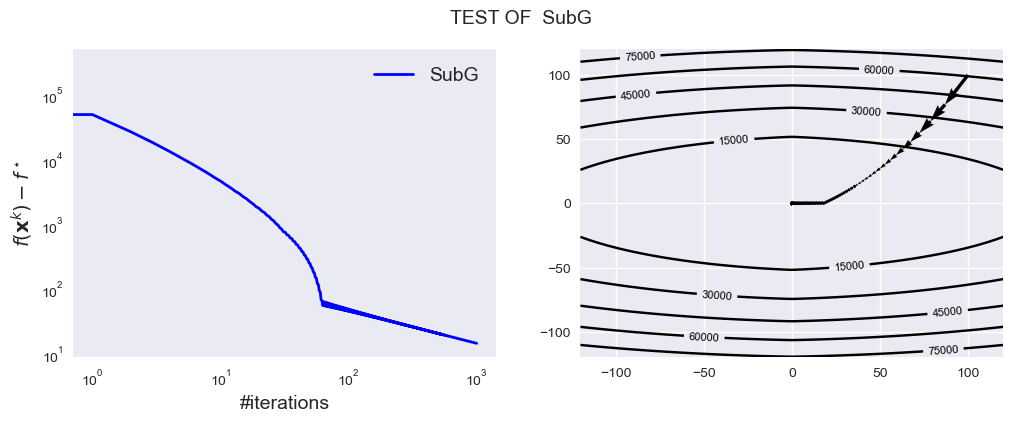

In [22]:
test_composite(SubG)


---

Another, more efficient approach, as we saw in Lecture 7, is to minimize such a function by using proximal gradient algorithms, provided that $g$ is _proximable_ (i.e., its proximal operator is efficient to evaluate). We recall the proximal operator of $g$ as the solution to the following convex problem:
$$
\mathrm{prox}_g(\mathbf{z}) := \mathrm{arg}\min_{\mathbf{y}\in\mathbb{R}^d}\{ g(\mathbf{y}) + \frac{1}{2}\Vert\mathbf{y} - \mathbf{z}\Vert_2^2\}.
$$

#### Question 2 (2 points)

Given $g_{\ell_1}: \mathbb{R}^p \rightarrow \mathbb{R}, \; g_{\ell_1}(\mathbf{x}) :=  \|\mathbf{x}\|_1$,  show that its proximal function can be written as
    $$
    \mathrm{prox}_{\gamma g_{\ell_1}}(\mathbf{z}) = \max(|\mathbf{z}|-\gamma,0) \circ \mathrm{sign}(\mathbf{z}), \; \text{for any }\mathbf{z} \in \mathbb{R}^p,\; \gamma \in \mathbb{R}_+
    $$
			where the operators $\max$, $\mathrm{sign}$ and $\lvert \cdot \lvert$ are applied coordinate-wise to the vector $\mathbf{z}$ and $\circ$ stands for $(\mathbf{x} \circ \mathbf{y})_i = x_i y_i$. Such a regularizer imposes sparsity on the solutions.


The proximal operator of $g_{\ell_1}$

$$
\mathrm{prox}_{\gamma g_{\ell_1}}(\mathbf{z})
= \arg\min_{\mathbf{y}\in\mathbb{R}^p} 
\left\{ \gamma\|\mathbf{y}\|_1 + \frac{1}{2}\|\mathbf{y}-\mathbf{z}\|_2^2 \right\}.
$$

Can be rewritten component wise as the objective is separable across coordinates, so we solve for each \( i \):

$$
\min_{y_i\in\mathbb{R}} \; \gamma |y_i| + \frac{1}{2}(y_i - z_i)^2.
$$

Using subgradients, the optimality condition is:

$$
0 \in \gamma \, \partial |y_i| + (y_i - z_i)
\quad \Leftrightarrow \quad
z_i - y_i \in \gamma \, \partial |y_i|.
$$

We consider three cases.

### Case 1. $ y_i > 0 $

Then  $\partial |y_i| = \{1\} $, so  

$$
z_i - y_i = \gamma \quad \Rightarrow \quad y_i = z_i - \gamma,
$$

valid if $ z_i > \gamma $.

### Case 2. $ y_i < 0 $

Then $ \partial |y_i| = \{-1\} $, so  

$$
z_i - y_i = -\gamma \quad \Rightarrow \quad y_i = z_i + \gamma,
$$

valid if $ z_i < -\gamma $.

### Case 3. $ y_i = 0 $

Then $ \partial |y_i| = [-1, 1] $, so  

$$
z_i \in \gamma[-1, 1] \quad \Leftrightarrow \quad |z_i| \le \gamma.
$$

Thus $ y_i = 0 $ is optimal.

We can now combine all the cases together :

$$
y_i =
\begin{cases}
z_i - \gamma, & \text{if } z_i > \gamma,\\[6pt]
0, & \text{if } |z_i| \le \gamma,\\[6pt]
z_i + \gamma, & \text{if } z_i < -\gamma.
\end{cases}
$$

Then we can comeback to the vector form to prove that :

$$
\boxed{
\mathrm{prox}_{\gamma g_{\ell_1}}(\mathbf{z})
= \max(|\mathbf{z}| - \gamma, 0) \circ \mathrm{sign}(\mathbf{z})
}
$$


#### Question 3 (1 point)
 Fill in the function `l1_prox` with the proximal operator of $g_{\ell_1}$.

In [23]:
def l1_prox(gamma, z):
    #FILL
    return np.sign(z) * np.maximum(np.abs(z) - gamma, 0)

#### Question 4 (4 points)

From here on, in order to speed-up the convergence of the optimization, let's assume that the function $f$ has been made to be $\mu$-strongly convex by the addition of an $\ell_2$ regularization term to the function $f$, while the $\ell_1$ term, $g$, has remained unchanged. As such, we must now utilize the strong-convexity versions of the composite optimization algorithms.

Using the information in Lecture 7 slide 21 fill in the codes of the method ISTA$_{\mu}$.

In [24]:
@dataclass
class ISTA_state(OptState):
    x_k: Vector
    #FILL

In [25]:
def ISTA_update(composite_function, state):
    #FILL
    f, g = composite_function
    L = f.lips_grad
    mu = f.strng_cvx
    alpha = 1/ (L + mu)
    x_next = l1_prox(alpha, state.x_k - alpha * f.grad(state.x_k))
    return ISTA_state(x_k = x_next)

def ISTA_initialize(composite_function, x_zero):
    #FILL
    f, g = composite_function
    alpha = 1/ (L + mu)
    x_1 = l1_prox(alpha, x_zero - alpha * f.grad(x_zero))
    return ISTA_state(x_k = x_1)

In [26]:
ISTA = OptAlgorithm(name="ISTA", init_state= ISTA_initialize, state_update=ISTA_update)

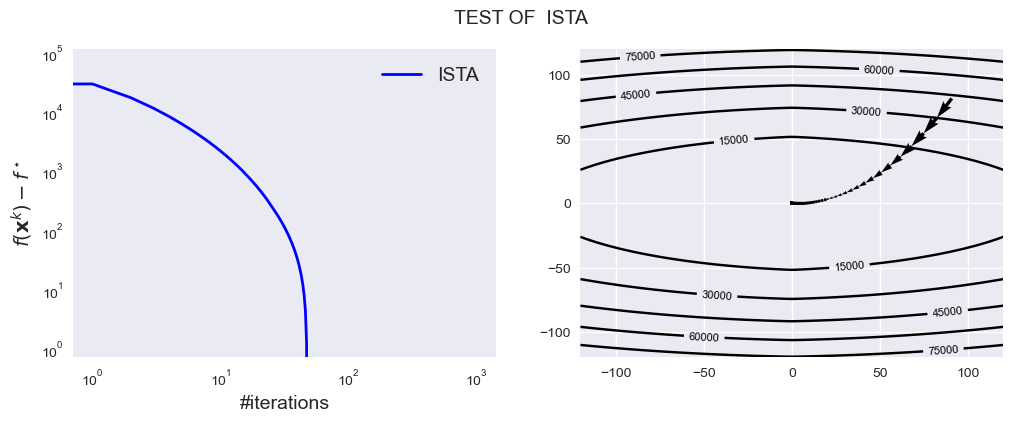

In [27]:
test_composite(ISTA)

#### Question 5  (7 points)

Using the information in Lecture 7 slide 21 fill in the codes of the method FISTA$_{\mu}$.

In [28]:
@dataclass 
class FISTA_state(OptState):
    x_k: Vector
    #FILL
    y_k : Vector

In [29]:
import numpy

def FISTA_update(composite_function, state):
    #FILL
    f, g = composite_function
    L = f.lips_grad
    mu = f.strng_cvx
    alpha = 1/L
    cf = L/mu
    x_next = l1_prox(alpha, state.y_k - alpha * f.grad(state.y_k))
    y_next = x_next + ((np.sqrt(cf)-1)/(np.sqrt(cf) + 1)) * (x_next - state.x_k)
    return FISTA_state(x_k=x_next,y_k=y_next)

def FISTA_initialize(composite_function, x_zero):
    #FILL
    f, g = composite_function
    L = f.lips_grad
    mu = f.strng_cvx
    y_zero = x_zero
    alpha = 1/L
    cf = L/mu
    x_1 = l1_prox(alpha, y_zero - alpha * f.grad(y_zero))
    y_1 = x_1 + ((np.sqrt(cf)-1)/(np.sqrt(cf) + 1)) * (x_1 - x_zero)
    return FISTA_state(x_k=x_1, y_k=y_1)
    

In [30]:
FISTA = OptAlgorithm(name="FISTA", init_state= FISTA_initialize, state_update=FISTA_update)

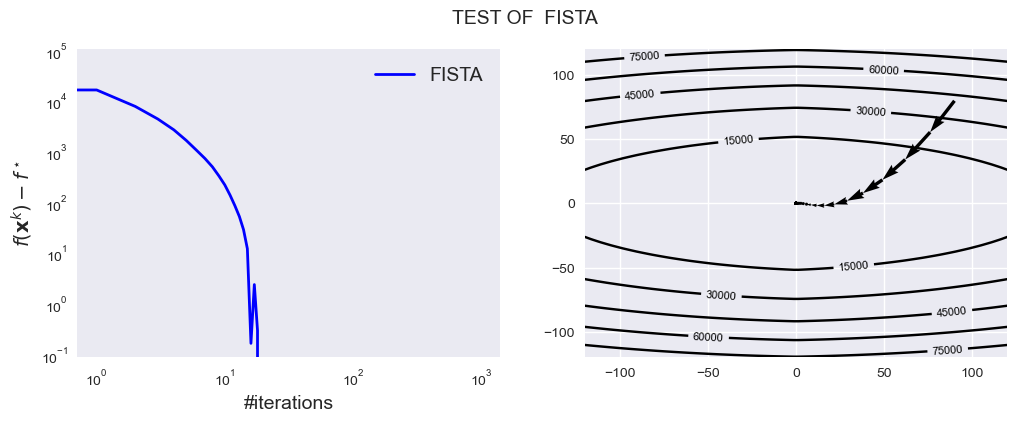

In [31]:
test_composite(FISTA)

#### Question 6  (2 points)

Compare the convergence rates of the three methods and analyze whether the observed results align with their theoretical bounds.

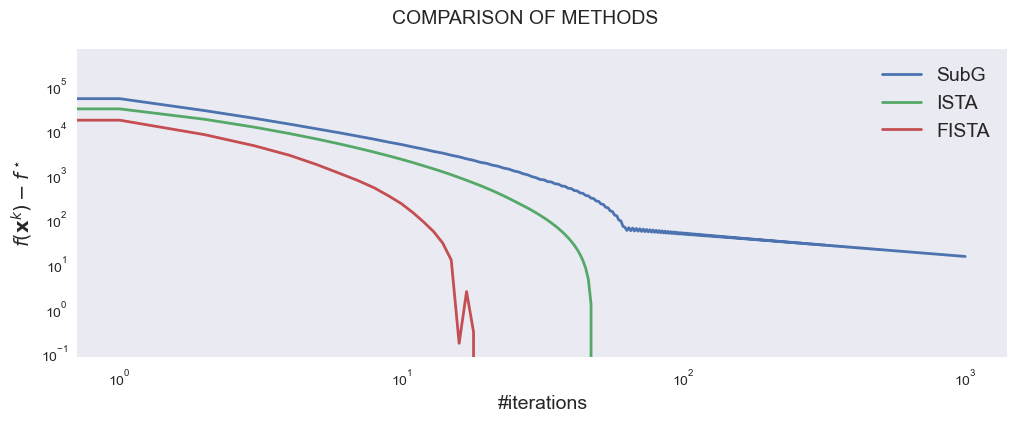

In [32]:
list_of_methods = [SubG, ISTA, FISTA]
compare_composite(list_of_methods)

Theretical bounds : 
    SubG  : cst * 1/sqrt(k)
    ISTA  : cst * 1/k
    FISTA : cst * 1/k^2

The plot shows us the expected result : FISTA converges faster than ISTA that converges faster than SubG.
The observed results align with their theoretical bounds

# Part 2: Application


We have now implemented multiple methods that can solve composite optimization problems. We will now apply them to an image inpainting problem.


Take a natural image, or better a picture of you, and place it in the same directory as this notebook.

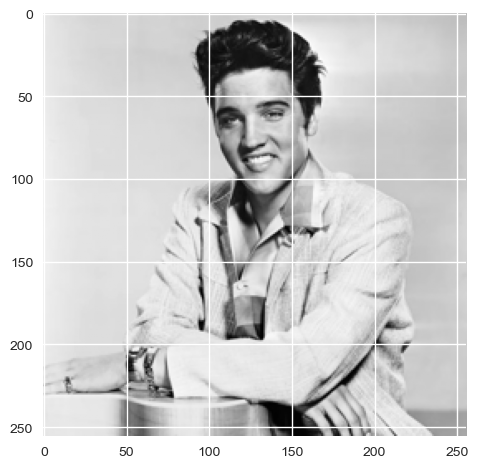

In [35]:
from lib.inpainting import *
image = load("lib/elvis.jpg") #FILL IN FILE NAME

With this image in hand, let us subsample it and try to reconstruct the original.

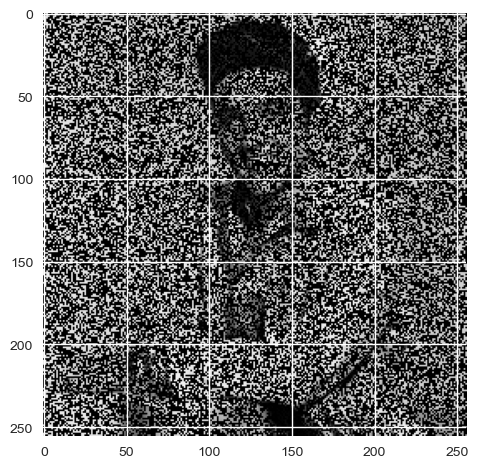

In [36]:
subsampled = show_subsampled(image)

For the rest of the questions, to ensure the function is 
$\mu$-strongly convex, we need to add an $\ell_2$ regularization term to it. As a result, we change the definition of $f_{\ell_1}(\mathbf{\alpha})$ as follows:
$$
    f_{\ell_1}(\mathbf{\alpha}) = \frac{1}{2}\|\mathbf{b} - \mathbf{P}_{\Omega} \mathbf{W}^T\mathbf{\alpha} \|_2^2 + \frac{1}{2}\mu \|\mathbf{\alpha}\|_2^2 
    $$

and the composite function becomes:
 $$
    \min_{\mathbf{\alpha} \in \mathbb{R}^{p}} \underbrace{ \frac{1}{2}\|\mathbf{b} - \mathbf{P}_{\Omega} \mathbf{W}^T\mathbf{\alpha} \|_2^2 + \frac{1}{2}\mu \|\mathbf{\alpha}\|_2^2 }_{f_{\ell_1}(\mathbf{\alpha})} + \underbrace{\lambda_{\ell_1} \|\mathbf{\alpha}\|_1}_{g_{\ell_1}(\mathbf{\alpha})},
    $$

By adding this regularization, we ensure better properties for optimization, making the solution more stable and well-behaved.

In the following cells we will define the optimization problems we need to solve to perform the reconstruction.

- We provide you with a function `P` that acts like the matrix $\mathbf{P}_{\Omega}$. That is, given a vector `x`, it returns a subsampled vector `P(x)` that corresponds to $\mathbf{P}_{\Omega} \mathbf{x}$. We also give you `P_T` which acts like $\mathbf{P}^\top$.
- We provide you with a function `W` and `W_T` that act like the matrix $\mathbf{W}$ and $\mathbf{W^\top}$ respectively. That is, for a vector `x`, `W(x)` and `W_T(x)` return $\mathbf{W}\mathbf{x}$ and $\mathbf{W^\top}\mathbf{x}$ respectively.

__(a)__ (1 point) Using these provided functions, define the observed variable `b` in the cell below.

In [37]:
from lib.inpainting import P, P_T, W, W_T

x = image.reshape(-1) #flattened image

b = P(x) #FILL

__(b)__ (1 point) Now define the function `f_l1` as described earlier in the problem text.

In [38]:
mu = 1e-4 # Desired strong convexity of f
def f_l1(alpha):
    return (1/2) * np.linalg.norm(b-P(W_T(alpha)), 2)**2 + (1/2)*mu*np.linalg.norm(alpha, 2)**2 #FILL

__(c)__ (1 point) Write the gradient of $f_{\ell_1}(\mathbf{\alpha})$.

In [39]:
def grad_f_l1(alpha):
    return - (W(P_T((b-P(W_T(alpha)))))) + mu*alpha #FILL

__(d)__ (1 points) Find the Lipschitz constant of $\nabla_\mathbf{\alpha} f_{\ell_1}(\mathbf{\alpha})$ analytically and fill it in the cell below. 

We know that
\begin{aligned}
\|\nabla f(x) - \nabla f(y)\|_2 
&\leq L*\| x-y\|_2 \\
\end{aligned}

Calculating the difference of the gradients in $x$ and $y$ yields

\begin{aligned}
\|\nabla f(x) - \nabla f(y)\|_2 
&= \| -W P^\top P W^\top (b - P W^\top x) + \mu x + W P^\top (b - P W^\top y) - \mu y \|_2 \\
&= \| W P^\top P W^\top x + \mu x - W P^\top P W^\top y - \mu y \|_2 \\
&= \| (W P^\top P W^\top + \mu I)(x - y) \|_2 \\
&\leq \| W P^\top P W^\top + \mu I \|_2 \, \|x - y\|_2
\end{aligned}

This implies $$ L = \| W P^\top P W^\top + \mu I \|_2 $$

As $W$ is an orthonormal matrix and $P$ is a sampling matrix only containing entries of 0 and 1, the biggest eigenvalue of the matrix and therefore the Lipschitz constant $L$ correspond to 1. The addition of $\mu$ which is equal to $10^{-4}$ can be neglected.

In [40]:
lips_grad_f_l1 = 1 #FILL

We have all the necessary ingredients to define the smooth part of our composite objective:

In [41]:
f_l1 = Function(f = f_l1, grad=grad_f_l1, lips_grad = lips_grad_f_l1, strng_cvx=mu)

For the non-smooth term, we define a regularizer built around the `l1` function that re-uses the `l1_prox` function you implemented earlier:

In [42]:
l1 = Function(f = lambda x: np.sum(np.abs(x), axis=0), prox=l1_prox)

g_l1 = Regularizer(l1)

In [43]:
composite_objective = CompositeFunction(f=f_l1, g=g_l1)

With the objective defined, we provide you with a function with the following signature:
```python
solve_composite(method: OptAlgorithm, composite_objective: CompositeFunction, lmda: float, max_iterations: int) -> Vector
```

In other words, the function takes an optimization algorithm `method`, a CompositeFunction `composite_objective`, a regularization parameter `lmda` and a number of iterations `max_iterations` and returns a vector which is the last iterate given by the `method`.



In [44]:
from lib.inpainting import solve_composite

__(e)__ (5 points) Using `solve_composite` reconstruct the subsampled image. Recall that the composite problem solves for $\mathbf{\alpha}$ so you need to convert the output back to an image and visualize it.

Select a reasonable value for `lmda` or (BONUS) using the function `solve_composite` and the `PSNR` metric, find the best value for `lmda`.

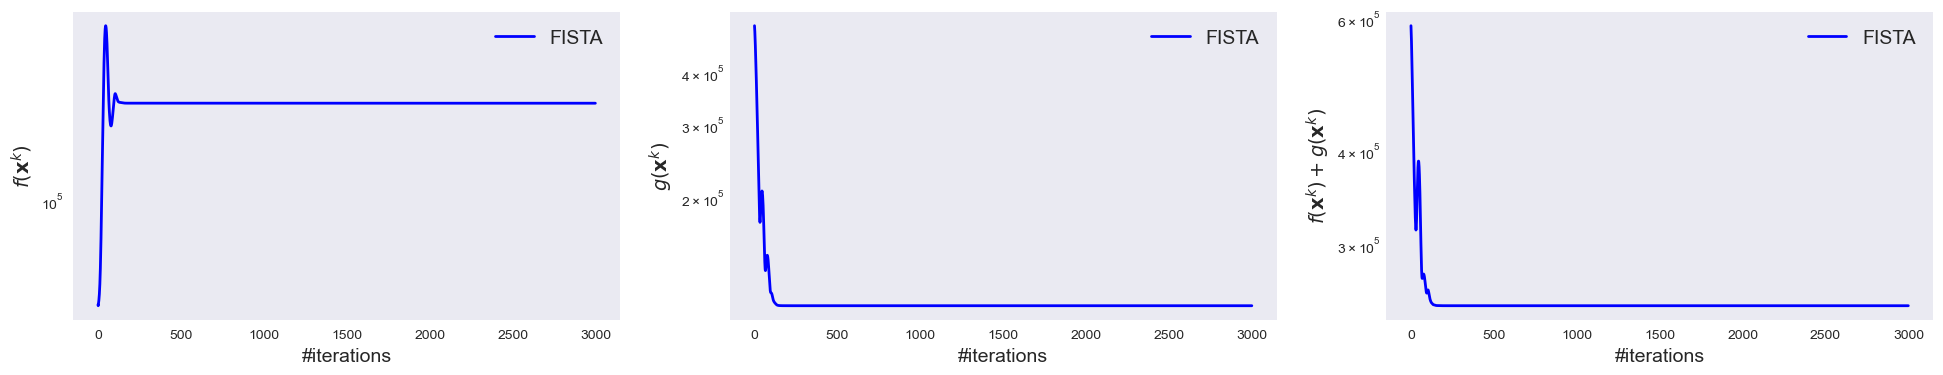

In [45]:
output = solve_composite(FISTA, composite_objective, lmda = 0.1, max_iterations= 3000)
flat_image_out = W_T(output)
image_out = flat_image_out.reshape(image.shape)

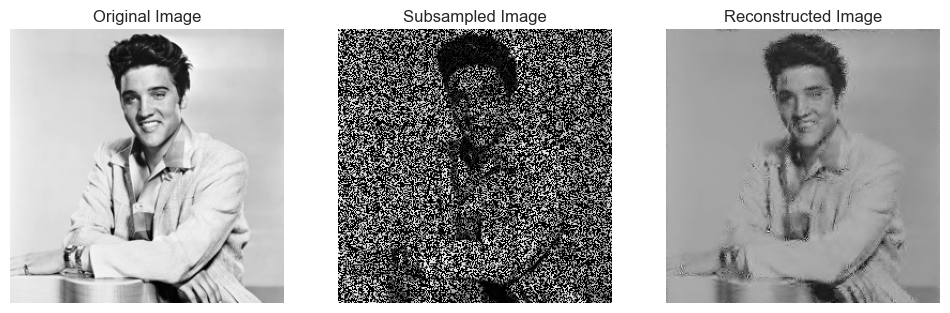

In [46]:
show(true = image, subsampled=subsampled, estimated=image_out)